In [65]:
''' required import '''

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import pytesseract
from selenium import webdriver

# debug mod
debug = False

In [66]:
''' chrome search '''

# constraint :
# nothing for the moment

# text init
text = 'fahrenheit 451 ray bradbury'


"""
return : initialized chrome driver
"""
def driverInit():
    
    # initialization
    PATH = "env/bin/chromedriver"
    driver = webdriver.Chrome(PATH)
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument('--ignore-certificate-errors')
    chrome_options.add_argument('--allow-running-insecure-content')
    chrome_options.add_argument("--window-size=1920,1080")
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(options=chrome_options)
    
    return driver
    

"""
text : text extract from bookspine (title, author, ...)
driver : initialized chrome driver
return : book description
"""
def chromeSearch(text, driver):
    
    # link build
    text = text.split(' ')
    link = 'https://www.google.com/search?q='
    first = True
    for t in text:
        if first:
            link = link + t
            first = False
        else:
            link = link + '+' +t
    driver.get(link)
    
    # scrapping
    title = driver.find_element_by_css_selector('[data-attrid="title"] > span')
    title = title.text
    subtitle = driver.find_element_by_css_selector('[data-attrid="subtitle"] > span')
    subtitle = subtitle.text
    result = title + ', ' + subtitle
    
    # debug
    if debug:
        print(link)
    
    # end
    driver.quit()
    
    return result

# driver init
driver = driverInit()

# show result
description = chromeSearch(text, driver)
print(description)

Fahrenheit 451, Roman de Ray Bradbury


In [67]:
''' some useful function '''

def noiseReducer(img, size):
    img = np.array(img)
    img = cv2.GaussianBlur(img, size, 0)
    img = Image.fromarray(img)
    
    return img

def polarCoordinateToLinearEquation(rho, theta, width, height):
    a0 = np.cos(theta)
    b0 = np.sin(theta)
    if a0 == 0: # y = rho
        X1 = 0
        Y1 = rho
        X2 = width
        Y2 = rho
    elif b0 == 0: # x = rho
        X1 = rho
        Y1 = 0
        X2 = rho
        Y2 = height
    else: # y = ax + b
        Xa = a0*rho
        Ya = b0*rho
        Xb = Xa+b0
        Yb = Ya-a0
        a = -a0/b0
        b = Ya - a*Xa
        x1 = -b/a
        y1 = 0
        x2 = (height-b)/a
        y2 = height
        x3 = 0
        y3 = b
        x4 = width
        y4 = a*width + b
        solution = []
        if 0<=x1 and x1<=width:
            solution.append((x1,y1))
        if 0<=x2 and x2<=width:
            solution.append((x2,y2))
        if 0<=y3 and y3<=height:
            solution.append((x3,y3))
        if 0<=y4 and y4<=height:
            solution.append((x4,y4))
        X1,Y1 = solution[0]
        X2,Y2 = solution[1]
    X1 = int(X1)
    Y1 = int(Y1)
    X2 = int(X2)
    Y2 = int(Y2)
    
    return X1, Y1, X2, Y2

In [68]:
''' text processing '''

# constraint :
# nothing for now


"""

"""
def textProcessing(texts):
    
    return None # work in progress

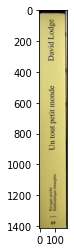

© | Gintbendee cxrangice Un tout petit monde David Lodge
S | Bionteneoce ttrangere Un tout petit monde David Lodge

Resse tian Un tout petit monde David LodgeHats


In [88]:
''' book spine processing '''

# constraint :
# doesn't work with book spine containing picture
# it's much better if the color is uniform

# image load
img = Image.open('../image/bookSpine/4.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))


"""
img : image of a book spine OR scrap image
return : book's information

note : should return anything for scrap image and don't lose time for them <-
"""
def bookSpineProcessing(img):
    
    width, height = img.size
    texts = []
    
    # rotation
    img = img.rotate(-90, expand = 1)
    img = np.array(img)
    
    # k-means clustering
    pixels = np.float32(img.reshape(-1, 3))
    n_colors = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    dominant = palette[np.argmax(counts)]
    
    # color 
    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    rows = np.int_(width*freqs)
    dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # OCR on gray
    text = pytesseract.image_to_string(gray)
    text = text.replace('\r', '').replace('\n', '')
    texts.append(text.strip())
    
    # binarisation 1
    binary1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    binary1 = Image.fromarray(binary1)
    
    # noise reducer
    binary1 = noiseReducer(binary1, (3, 3))
    
    # OCR on binary 1
    text = pytesseract.image_to_string(binary1)
    text = text.replace('\r', '').replace('\n', '')
    texts.append(text.strip())
    
    # binarisation 2
    binary2 = cv2.threshold(gray, 176, 255, cv2.THRESH_BINARY)[1]
    binary2 = Image.fromarray(binary2)
    
    # noise reducer
    binary2 = noiseReducer(binary2, (3, 3))
    
    # OCR on binary 2
    text = pytesseract.image_to_string(binary2)
    text = text.replace('\r', '').replace('\n', '')
    texts.append(text.strip())
    
    # binarisation 3
    binary3 = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)[1]
    binary3 = Image.fromarray(binary3)
    
    # noise reducer
    binary3 = noiseReducer(binary3, (3, 3))
    
    # OCR on binary 3
    text = pytesseract.image_to_string(binary3)
    text = text.replace('\r', '').replace('\n', '')
    texts.append(text.strip())
    
    # debug
    if debug:
        plt.imshow(img)
        plt.show()
        plt.imshow(dom_patch)
        plt.show()
        print(dominant)
        plt.imshow(gray, cmap='gray')
        plt.show()
        plt.imshow(binary1, cmap='gray')
        plt.show()
        plt.imshow(binary2, cmap='gray')
        plt.show()
        plt.imshow(binary3, cmap='gray')
        plt.show()
    
    return texts # no color for now

# show result
texts = bookSpineProcessing(img)
for text in texts:
    print(text)

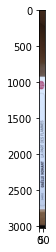

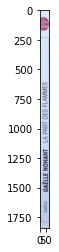

In [70]:
''' book spine extraction '''

# constraint :
# nothing for now

# image load
img = Image.open('../image/noisyBookSpine/3')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))


"""
img : image of a noisy book spine
return : book spine
"""
def bookSpineExtraction(img):
    
    width, height = img.size
    img = np.array(img)
    
    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 10, 100) 

    # hough transform
    threshold = width//2
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    if lines is None:
        lines = [[]]
    coordinate.append((0,0))
    for line in lines:
        for rho,theta in line:
            if np.pi/2-0.01<theta and theta<np.pi/2+0.01:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((y1,y2))
    coordinate.append((height,height))
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = height//10
    for y1,y2 in coordinate:
        if (last != None and last<min(y1,y2)-threshold):
            # crop
            im = img.crop((0, last, width, max(y1,y2)))
            w,h = im.size
            # add it
            croppedImg.append((h,im))
        last = min(y1,y2)
    croppedImg.sort(reverse=True, key = lambda x: x[0])
    i, img = croppedImg[0]
    
    # debug
    if debug:
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.imshow(houghTransform)
        plt.show()
    
    return img

img = bookSpineExtraction(img)
plt.imshow(img)
plt.show()

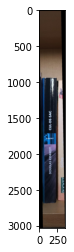

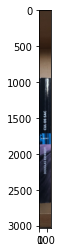

In [71]:
''' row segmentation lvl2 '''

# constraint :
# nothing for now

# image load
img = Image.open('../image/noisyBookSpine/9')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))


"""
img : image of a noisy book spine
return : list of book spine
"""
def rowSegmentation2(img):
    
    width, height = img.size
    img = np.array(img)

    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = ( cv2.HoughLines(edges, 1, np.pi/180, threshold))
    if lines is None:
        lines = [[]]
    coordinate.append((0,0))
    for line in lines:
        for rho,theta in line:
            if theta<np.pi/2-0.3 or np.pi/2+0.3<theta:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((x1,x2))
    coordinate.append((width,width))
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = width//5
    for x1,x2 in coordinate:
        if (last != None and last<min(x1,x2)-threshold):
            # crop
            im = img.crop((last, 0, max(x1,x2), height))
            # add it
            croppedImg.append(im)
        last = min(x1,x2)
        
    # debug
    if debug:
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.imshow(houghTransform)
        plt.show()
        
    return croppedImg

images = rowSegmentation2(img)
for im in images:
    plt.imshow(im)
    plt.show()

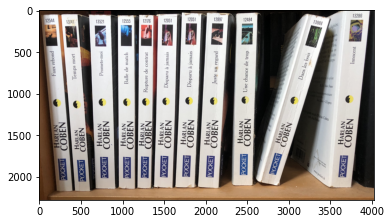

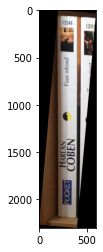

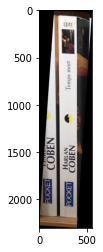

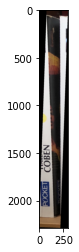

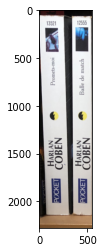

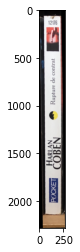

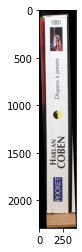

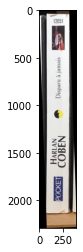

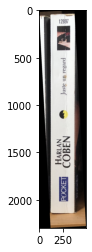

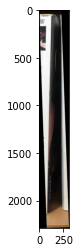

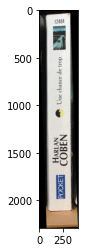

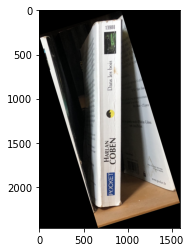

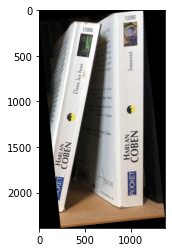

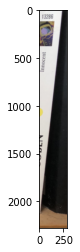

'\nimages = rowSegmentation1(img)\nliste = []\nfor im in images:\n    liste = liste + rowSegmentation2(im)\nliste2 = []\nfor im in liste:\n    liste2.append(bookSpineExtraction(im))\nfor im in liste2:\n    bookSpineProcessing(im)\n'

In [72]:
''' row segmentation lvl1 '''

# constraint : 
# doesn't work with thin book spines
# doesn't work with horizontal book spines
# only book spines should apear

# image load
img = Image.open('../image/bookRow/7.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))

"""
img : image of a book row
return : list of noisy book spines
"""
def rowSegmentation1(img):
    
    width, height = img.size
    img = np.array(img)
    
    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150) 

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    if lines is None:
        lines = [[]]
    coordinate.append((0,0,0))
    for line in lines:
        for rho,theta in line:
            if theta<np.pi/2-0.3 or np.pi/2+0.3<theta:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((x1,x2,theta))
    coordinate.append((width,width,0))
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = width/50
    for x1,x2,theta in coordinate:
        if (last != None and last<min(x1,x2)-threshold):
            # crop
            im = img.crop((last, 0, max(x1,x2), height))
            # rotate
            theta = math.degrees(theta)
            if theta>90:
                theta = theta-180
            else:
                theta = theta
            im = im.rotate(theta, expand = 1)
            # add it
            croppedImg.append(im)
        last = min(x1,x2)
        
    # debug
    if debug:
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.imshow(houghTransform)
        plt.show()
    
    return croppedImg

# show result
images = rowSegmentation1(img)
for im in images:
    plt.imshow(im)
    plt.show()


"""
images = rowSegmentation1(img)
liste = []
for im in images:
    liste = liste + rowSegmentation2(im)
liste2 = []
for im in liste:
    liste2.append(bookSpineExtraction(im))
for im in liste2:
    bookSpineProcessing(im)
"""

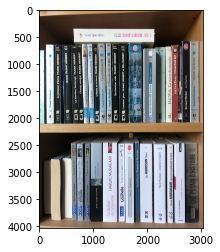

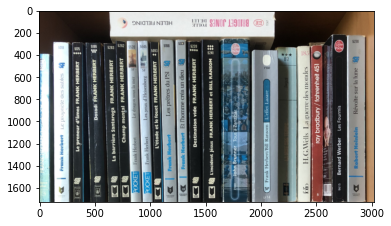

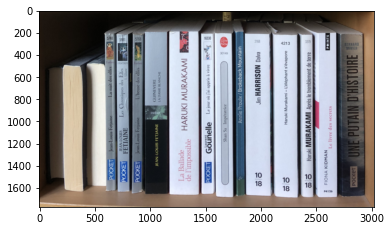

In [73]:
''' bookshelf segmentation '''

# constraint : 
# doesn't work with thin book spines 
# doesn't work with low definition image

# image load
img = Image.open('../image//bookshelf/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))


"""
img : image of a vertical bookshelf
return : list of book rows
"""
def bookshelfSegmentation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # histogram equalizer
    eq = cv2.equalizeHist(gray)

    # canny filter
    edges = cv2.Canny(eq, 50, 200)

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    if lines is None:
        lines = [[]]
    coordinate.append(0)
    for line in lines:
        for rho,theta in line:
            if np.pi/2-0.1<theta and theta<np.pi/2+0.1:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((y1+y2)//2)
    coordinate.append(height)

    # crop image
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = height/10
    for y in coordinate:
        if (last != None and last<y-threshold):
            croppedImg.append(img.crop((0, last, width, y)))
        last = y
        
    # debug
    if debug:
        plt.imshow(gray, cmap='gray')
        plt.show()
        plt.imshow(eq, cmap='gray')
        plt.show()
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.imshow(houghTransform)
        plt.show()
    
    return croppedImg

# show result
images = bookshelfSegmentation(img)
for im in images:
    plt.imshow(im)
    plt.show()

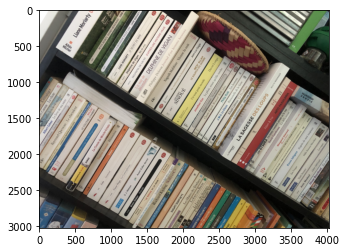

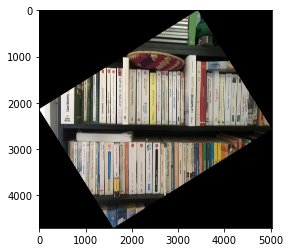

In [74]:
''' bookshelf orientation '''

# constraint : 
# the majority of the books must be well oriented
# the image should not be too askew

# image load
img = Image.open('../image/askewBookshelf/1.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))

"""
img : askew image of bookshelf
return : reoriented image
"""
def bookshelfOrientation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)

    # hough transform
    treshold = 500
    lines = cv2.HoughLines(edges, 1, np.pi/180, treshold)
    length = max(width, height)
    angles = []
    houghTransform = img.copy()
    if lines is None:
        lines = [[]]
    for line in lines:
        for rho,theta in line:
            x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
            houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
            angles.append(theta)
    
    # orientation
    angles.sort()
    theta = angles[len(angles)//2]
    theta = math.degrees(theta)
    if theta>90:
        theta = theta - 180
    img = Image.fromarray(img, 'RGB')
    img = img.rotate(theta, expand = 1)
    
    # debug
    if debug:
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.imshow(houghTransform)
        plt.show()
    
    return img

# show result
img = bookshelfOrientation(img)
plt.imshow(img)
plt.show()

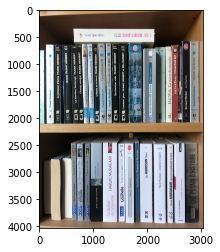

In [76]:
''' all process '''

# image load
img = Image.open('../image/bookshelf/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img, (7, 7))

# orientation
reoriented = bookshelfOrientation(img)

# bookshelf segmentation
rows = bookshelfSegmentation(reoriented)

# row segmentation 1
row1 = []
for im in rows:
    spines = rowSegmentation1(im)
    row1 = row1 + spines
    
# row segmentation 2
row2 = []
for im in row1:
    spines = rowSegmentation2(im)
    row2 = row2 + spines

# spine extraction
bookSpine = []
for im in row2:
    bookSpine.append(bookSpineExtraction(im))

# book spine processing
for book in bookSpine:
    bookSpineProcessing(book)